In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("./..")
sys.path.append(".")

In [15]:
from pathlib import Path
import pprint
import hashlib

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from dotted_dict import DottedDict
from tqdm import tqdm
#
from effcn.layers import View#, Squash
from effcn.functions import margin_loss, masking, margin_loss_cnn_r
from effcn.models import MnistEffCapsNet, MnistEcnDecoder, CNN_CR_SF, CNN_CR, CNN_R
from effcn.utils import count_parameters

In [5]:
transform_train = T.Compose([
    T.RandomAffine(
        degrees=(-30, 30),
        shear=(-30, 30),
        # translate=(0.9, 0.9),
    ),
    T.RandomResizedCrop(
        28,
        scale=(0.8, 1.2),
        ratio=(1, 1),
    ),
    T.ToTensor()
])
transform_valid = T.Compose([
    T.ToTensor()
])

In [6]:
ds_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
ds_valid = datasets.MNIST(root="./data", train=False, download=True, transform=transform_valid)

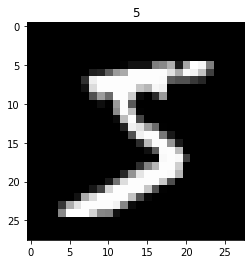

In [7]:
plt.imshow(ds_train.data[0], cmap='gray')
plt.title('%i' % ds_train.targets[0])
plt.show()

In [8]:
dl_train = torch.utils.data.DataLoader(ds_train, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                          batch_size=16, 
                                          shuffle=True, 
                                          num_workers=4)

In [143]:
class Squash(nn.Module):
    def __init__(self, eps=0):#1e-21):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        """
         IN:  (b, n, d)
         OUT: squash(x(b,n,d))
        """
        x_norm = torch.norm(x, dim=2, keepdim=True)
        return (1 - 1 / (torch.exp(x_norm) + self.eps)) * (x / (x_norm + self.eps))

#### CNN_CR

In [144]:
class CNN_CR_Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=256,            
                kernel_size=9,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(256, 256, 9, 2),     
            nn.ReLU(),                                 
        )
        self.fc1 = nn.Linear(256 * 6 * 6, 10 * 16)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)        
        x = x.view(-1,10,16)
        return x

In [145]:
class CNN_CR(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = CNN_CR_Backbone()
        self.decoder = MnistEcnDecoder()

    def forward(self, x, y_true=None):
        """
            IN:
                x (b, 1, 28, 28)
            OUT:
                u_h
                    (b, n_h, d_h)
                    output caps
                x_rec
                    (b, 1, 28, 28)
                    reconstruction of x
        """

        u_h = self.backbone(x)

        u_h_masked = masking(u_h, y_true)
        x_rec = self.decoder(u_h_masked)

        return u_h, x_rec        

#### CNN_CR_SF

In [146]:
class CNN_CR_SF_Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=256,            
                kernel_size=9,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(256, 256, 9, 2),     
            nn.ReLU(),                                 
        )
        self.fc1 = nn.Linear(256 * 6 * 6, 16 * 8)
        self.sq = Squash(eps=1e-20)
        self.fc2 =  nn.Linear(16 * 8, 16 * 10)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = x.view(-1,16,8)
        x = self.sq(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc2(x)
        x = x.view(-1,10,16)
        x = self.sq(x)
        return x

In [147]:
class CNN_CR_SF(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = CNN_CR_SF_Backbone()
        self.decoder = MnistEcnDecoder()

    def forward(self, x, y_true=None):
        """
            IN:
                x (b, 1, 28, 28)
            OUT:
                u_h
                    (b, n_h, d_h)
                    output caps
                x_rec
                    (b, 1, 28, 28)
                    reconstruction of x
        """

        u_h = self.backbone(x)

        u_h_masked = masking(u_h, y_true)
        x_rec = self.decoder(u_h_masked)

        return u_h, x_rec 

#### CNN_R

In [148]:
class CNN_R_Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=256,            
                kernel_size=9,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(256, 256, 9, 2),     
            nn.ReLU(),                                 
        )
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)        
        x = x.view(-1,10)
        return x

In [149]:
class CNN_R_Decoder(nn.Module):
    """
        Decoder model from Efficient-CapsNet for MNIST
    """

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
            IN:
                x (b, n, d) with n=10 and d=16
            OUT:
                x_rec (b, 1, 28, 28)
            Notes:
                input must be masked!
        """
        x = self.layers(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [150]:
class CNN_R(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = CNN_R_Backbone()
        self.decoder = CNN_R_Decoder()

    def forward(self, x):
        """
            IN:
                x (b, 1, 28, 28)
            OUT:
                u_h
                    (b, n_h, d_h)
                    output caps
                x_rec
                    (b, 1, 28, 28)
                    reconstruction of x
        """

        y_pred = self.backbone(x)
        x_rec = self.decoder(y_pred)

        return y_pred, x_rec        

In [10]:
def margin_loss_cnn_r(u, y_true, lbd=0.5, m_plus=0.9, m_minus=0.1):
    """
    IN:
        u      (b,n,d)  ... capsules with n equals the numbe of classes
        y_true (b,n)    .... labels vector, categorical representation
    OUT:
        loss, scalar
    """

    #u_norm = torch.norm(u, dim=2)
    term_left = torch.square(F.relu(m_plus - u))
    term_right = torch.square(F.relu(u - m_minus))
    #
    loss = y_true * term_left + lbd * (1.0 - y_true) * term_right
    loss = loss.sum(dim=1).mean()
    return loss

#### shapes

In [9]:
model = CNN_CR_SF()
#model = CNN_CR()
img, y = next(iter(dl_train))

u, rec = model(img)

print(img.shape)
print(u.shape)
print(y.shape)

y_one_hot = F.one_hot(y, num_classes=10)
print(y_one_hot.shape)
print(margin_loss(u, y_one_hot))
print(rec.shape)

print(u.max())
print(u.min())
print(u.mean())

torch.Size([256, 1, 28, 28])
torch.Size([256, 10, 16])
torch.Size([256])
torch.Size([256, 10])
tensor(0.5378, grad_fn=<MeanBackward0>)
torch.Size([256, 1, 28, 28])
tensor(0.2001, grad_fn=<MaxBackward1>)
tensor(-0.1451, grad_fn=<MinBackward1>)
tensor(0.0047, grad_fn=<MeanBackward0>)


In [10]:
model = CNN_R()
img, y = next(iter(dl_train))
u, rec = model(img)

print(img.shape)
print(u.shape)
print(y.shape)

y_one_hot = F.one_hot(y, num_classes=10)
print(y_one_hot)
print(margin_loss_cnn_r(u, y_one_hot))
print(rec.shape)

print(u.max())
print(u.min())
print(u.mean())

torch.Size([256, 1, 28, 28])
torch.Size([256, 10])
torch.Size([256])
tensor([[0, 0, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor(0.8164, grad_fn=<MeanBackward0>)
torch.Size([256, 1, 28, 28])
tensor(0.1608, grad_fn=<MaxBackward1>)
tensor(-0.1027, grad_fn=<MinBackward1>)
tensor(-0.0017, grad_fn=<MeanBackward0>)


In [154]:
"""
#ccn shape tp caps shape
z = torch.zeros([1, 256, 6, 6])
z.fill_(1)
z = torch.flatten(z, start_dim=1)
z = nn.Linear(256 * 6 * 6, 16 * 8)(z)
z = z.view(-1,16,8)
z.shape
"""

'\n#ccn shape tp caps shape\nz = torch.zeros([1, 256, 6, 6])\nz.fill_(1)\nz = torch.flatten(z, start_dim=1)\nz = nn.Linear(256 * 6 * 6, 16 * 8)(z)\nz = z.view(-1,16,8)\nz.shape\n'

### Train Test

In [11]:
if torch.cuda.is_available():
    dev = "cuda" 
else:  
    dev = "cpu"  
device = torch.device(dev)
print(device)

cuda


In [16]:
#model = CNN_R()
#model = CNN_CR()
#model = CNN_CR_SF()
model = MnistEffCapsNet()
model.to(device)


if model.__class__.__name__ == "CNN_R":
    print('fine')
else:
    print('bla')
model.__class__.__name__

bla


'MnistEffCapsNet'

In [17]:
 print("#params: {}".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr = 5e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)


#params: 1573168


In [18]:
num_epochs = 10
for epoch_idx in range(1, num_epochs+1):
    
    model.train()
    epoch_correct = 0
    epoch_total = 0
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)

        # clear gradients for this training step   
        for param in model.parameters():
            param.grad = None
        
        u_h, x_rec = model.forward(x)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=10)
        if model.__class__.__name__ == "CNN_R":
            loss_margin = margin_loss_cnn_r(u_h, y_one_hot)
        else:
            loss_margin = margin_loss(u_h, y_one_hot)
        loss_rec = torch.nn.functional.mse_loss(x, x_rec)
        
        # param from paper
        loss = loss_margin + 0.392 * loss_rec
        loss.backward()
        
        optimizer.step()

        if model.__class__.__name__ == "CNN_R":
            y_pred = torch.argmax(u_h, dim=1)
        else:        
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)

        batch_correct = (y_true == y_pred).sum()
        batch_total = y_true.shape[0]
        acc = batch_correct / batch_total

        epoch_correct += batch_correct
        epoch_total += batch_total

        pbar.set_postfix(
                {'loss': loss.item(),
                    'mar': loss_margin.item(),
                    'rec': loss_rec.item(),
                    'acc': acc.item()
                }
        )

Train [  1/ 10]:██████████| 235/235 [00:05<00:00, 41.24it/s, loss=0.0921, mar=0.0688, rec=0.0596, acc=0.958]
Train [  2/ 10]:██████████| 235/235 [00:05<00:00, 41.51it/s, loss=0.0768, mar=0.0537, rec=0.0589, acc=0.99] 
Train [  3/ 10]:███████▎  | 172/235 [00:04<00:01, 40.70it/s, loss=0.0738, mar=0.0501, rec=0.0605, acc=0.969]


KeyboardInterrupt: 

In [ ]:
model.eval()
    
epoch_correct = 0
epoch_total = 0

for x,y_true in dl_valid:
    x = x.to(device)
    y_true = y_true.to(device)
        
    with torch.no_grad():
        u_h, x_rec = model.forward(x)
        if model.__class__.__name__ == "CNN_R":
            y_pred = torch.argmax(u_h, dim=1)
        else:        
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)

        epoch_correct += (y_true == y_pred).sum()
        epoch_total += y_true.shape[0]

print("   acc_valid: {:.5f}".format(epoch_correct / epoch_total))    

   acc_valid: 0.98650


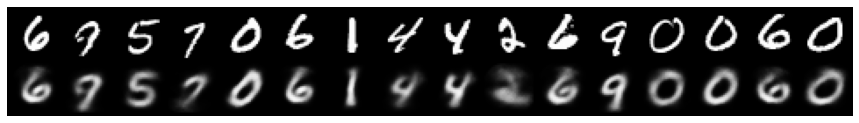

In [ ]:
x_vis, y_vis = next(iter(dl_valid))
with torch.no_grad():
    _, x_rec = model.forward(x_vis.to(device))
x_rec = x_rec.cpu()
img = torchvision.utils.make_grid(torch.cat([x_vis[:16], x_rec[:16]], dim=0), nrow=16)
img = img.permute(1,2,0)
plt.figure(figsize=(16, 2))
plt.tight_layout()
plt.axis('off')
plt.imshow(img)
